In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from wavhandler import *
from utils import *

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')

# Creating dataframes that contain PSDs for each insect class

In [3]:
sz = 500
df_an = make_df_parallel(df_mosquitos, setting='psd', insect_class='Anopheles', sample_size=sz).T
df_an['label'] = 'an'
df_ae = make_df_parallel(df_mosquitos, setting='psd',insect_class='Aedes', sample_size=sz).T
df_ae['label'] = 'ae'
df_cu = make_df_parallel(df_mosquitos, setting='psd',insect_class='Culex', sample_size=sz).T
df_cu['label'] = 'cu'

/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child processes.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child processes.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child processes.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 10] No child p

In [4]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='any', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(labelarray.shape)

(1500, 130)
(1500, 130)
(1500,)


### Example PSD

In [5]:
# df_concat.iloc[9,:-1].plot()

## Principal Component Analysis (traditional)

In [26]:
from sklearn.preprocessing import StandardScaler

X = df_concat.iloc[:,:-1].values

idx = np.random.randint(X.shape[0], size=3000)
X = X[idx,:]

labelarray = labelarray[idx]
y = labelarray

X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)

cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix 
[[1.00033344 0.7704015  0.59386495 ... 0.22249184 0.22250666 0.22252958]
 [0.7704015  1.00033344 0.74398578 ... 0.2203267  0.22020393 0.22014789]
 [0.59386495 0.74398578 1.00033344 ... 0.37114815 0.37072673 0.37050661]
 ...
 [0.22249184 0.2203267  0.37114815 ... 1.00033344 1.00033301 1.0003324 ]
 [0.22250666 0.22020393 0.37072673 ... 1.00033301 1.00033344 1.00033331]
 [0.22252958 0.22014789 0.37050661 ... 1.0003324  1.00033331 1.00033344]]
NumPy covariance matrix: 
[[1.00033344 0.7704015  0.59386495 ... 0.22249184 0.22250666 0.22252958]
 [0.7704015  1.00033344 0.74398578 ... 0.2203267  0.22020393 0.22014789]
 [0.59386495 0.74398578 1.00033344 ... 0.37114815 0.37072673 0.37050661]
 ...
 [0.22249184 0.2203267  0.37114815 ... 1.00033344 1.00033301 1.0003324 ]
 [0.22250666 0.22020393 0.37072673 ... 1.00033301 1.00033344 1.00033331]
 [0.22252958 0.22014789 0.37050661 ... 1.0003324  1.00033331 1.00033344]]
Eigenvectors 
[[ 5.36059647e-02  2.53546795e-02 -7.33939275e-02 ...

In [27]:
u,s,v = np.linalg.svd(X_std.T)
print(u)
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for q,i in enumerate(eig_pairs):
    print(i[0])
    if q>10:
        break

[[-5.36059647e-02  2.53546795e-02 -7.33939275e-02 ...  2.50708795e-05
   5.76858652e-06  1.61521213e-06]
 [-6.18102002e-02  3.84477892e-02 -5.29764226e-02 ... -2.93844492e-05
  -1.07141219e-05 -1.78417623e-06]
 [-1.07399495e-01  6.11839002e-02 -5.37571563e-02 ... -3.83166057e-06
   2.13885795e-05  6.68274892e-06]
 ...
 [-9.56623574e-02 -2.20749811e-01 -8.51310564e-03 ...  4.60681605e-01
   7.59950564e-01 -1.18713899e-01]
 [-9.55826778e-02 -2.20891772e-01 -8.52346664e-03 ...  1.84934050e-01
  -5.03776452e-01 -6.77590185e-01]
 [-9.55402586e-02 -2.20966346e-01 -8.53192275e-03 ...  2.61515465e-01
  -3.45601618e-01  7.24988809e-01]]
Everything ok!
Eigenvalues in descending order:
49.391470346953355
11.116939052979461
6.641160091021398
6.140682107515238
5.910829400903694
4.895437435588408
3.9315582729409004
3.624933067602763
3.2748346071682284
2.621328628988406
2.4009686337175333
2.1707554556436874


In [57]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp = cum_var_exp[:10]
var_exp = var_exp[:10]

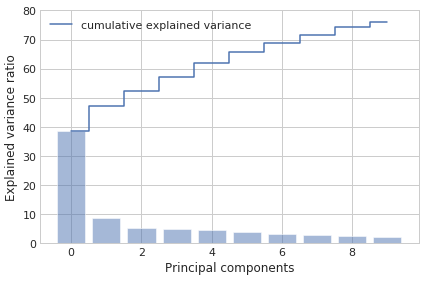

In [58]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), np.array(var_exp), alpha=0.5)
    plt.step(range(len(var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [29]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(128,1),
                      eig_pairs[1][1].reshape(128,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[ 0.05360596  0.02535468]
 [ 0.0618102   0.03844779]
 [ 0.10739949  0.0611839 ]
 [ 0.12014851  0.07224454]
 [ 0.12034023  0.07936984]
 [ 0.12339945  0.08493904]
 [ 0.12805331  0.08539049]
 [ 0.12908818  0.08524766]
 [ 0.12969477  0.08814795]
 [ 0.1243239   0.08505493]
 [ 0.04167342  0.03721519]
 [ 0.01141586  0.02456783]
 [ 0.00050534  0.01156598]
 [-0.00551605  0.00413388]
 [-0.01237431  0.00656304]
 [-0.01618885  0.00804323]
 [-0.00964746 -0.0073811 ]
 [-0.00492585  0.00435567]
 [-0.00257052  0.00458498]
 [ 0.00313888 -0.00912072]
 [ 0.01202142 -0.02557055]
 [ 0.01892781 -0.0223134 ]
 [ 0.02120899 -0.00582135]
 [ 0.02074899  0.00855581]
 [ 0.00965285  0.02244654]
 [ 0.00730974  0.00357699]
 [ 0.0085756  -0.01076861]
 [ 0.00374133 -0.0246869 ]
 [-0.00358881 -0.02039241]
 [-0.0075812  -0.00935456]
 [-0.00866002 -0.00506207]
 [-0.00453756 -0.01920465]
 [-0.00227683 -0.01813108]
 [ 0.00054324 -0.01460415]
 [-0.00059378 -0.00345346]
 [ 0.00099358  0.0057779 ]
 [-0.00040673  0.

In [30]:
Y = X_std.dot(matrix_w)

In [33]:
np.unique(y)

array(['ae', 'an', 'cu'], dtype=object)

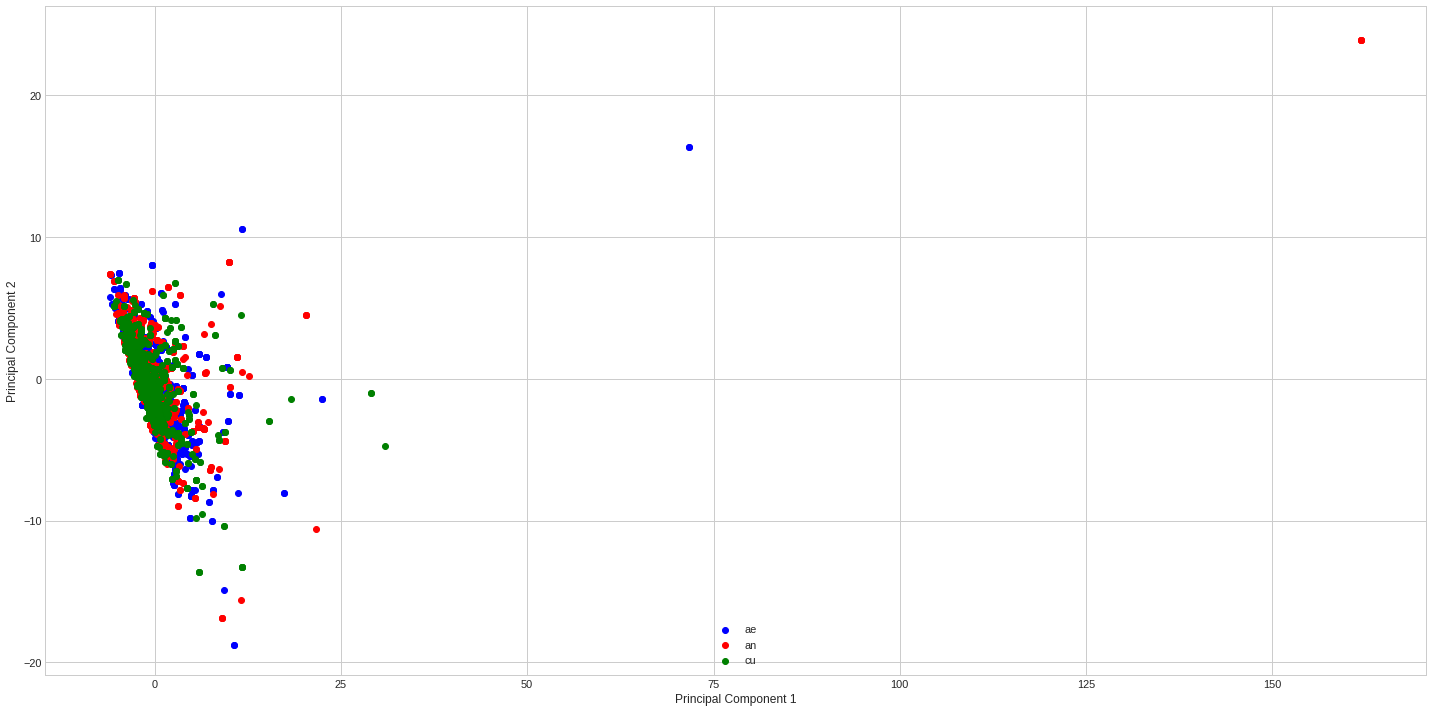

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20, 10))
    for lab, col in zip(('ae', 'an', 'cu'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [38]:
Y

array([[-2.04068254, -0.07060504],
       [-3.02741661,  2.91148971],
       [-1.39125618,  2.7358917 ],
       ...,
       [22.40268952, -1.40719513],
       [ 0.36146733, -2.89106537],
       [ 1.40531194,  0.27606716]])

# Principal Component Analysis (sklearn)

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_concat.iloc[:,:-1].values
idx = np.random.randint(X.shape[0], size=3000)
X = X[idx,:]
labelarray = labelarray[idx]
X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data

ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
Χ_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

EXPLAINED VARIANCE with 2 components: 0.34


## Plotting PCA scores (The first two components)

Text(0, 0.5, 'component 2')

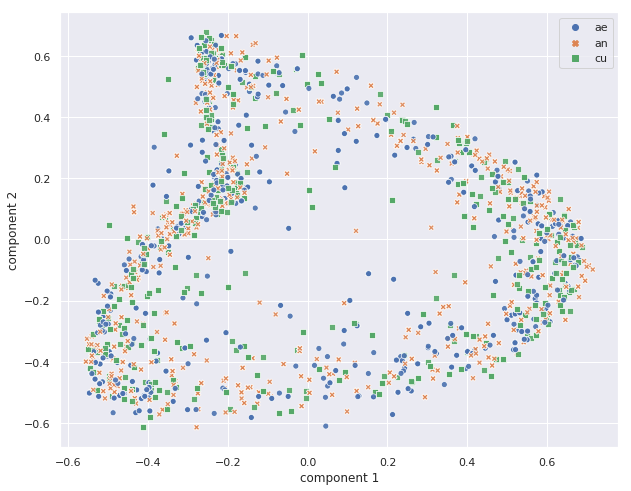

In [90]:
plt.figure(figsize=(10,8))
sns.scatterplot(Χ_final[:,0], Χ_final[:,1], hue=labelarray, style=labelarray, alpha=0.9)
plt.xlabel('component 1')
plt.ylabel('component 2')

In [91]:
df_pca = pd.DataFrame(pca.components_,index = ['PC-1','PC-2'])#, 'PC-3'])
df_pca

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
PC-1,0.000115,0.000108,0.000184,0.000747,0.001134,0.000745,0.000454,0.000379,0.000295,0.0005,...,-2.282069e-08,-2.146093e-08,-2.110493e-08,-2.021947e-08,-1.957447e-08,-1.908503e-08,-1.868154e-08,-1.835962e-08,-1.813648e-08,-1.800157e-08
PC-2,-0.000028,-0.000009,0.000139,0.000407,0.000531,0.000621,0.000611,0.000538,0.000515,0.0006,...,5.441365e-08,5.378476e-08,5.267317e-08,5.199374e-08,5.124892e-08,5.072738e-08,5.024313e-08,4.990112e-08,4.964876e-08,4.949870e-08


In [92]:
pca.components_.shape

(2, 128)

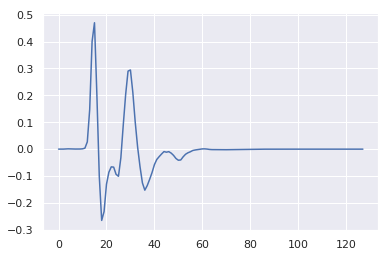

In [93]:
df_pca.loc['PC-1'].plot()

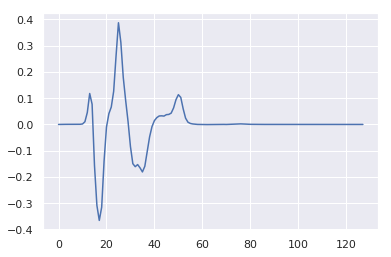

In [94]:
df_pca.loc['PC-2'].plot()

In [95]:
#df_pca.loc['PC-3'].plot()

# 3D Plot (PCA scores, 3 components)

In [14]:
import plotly
import plotly.plotly as py
from sklearn.preprocessing import LabelEncoder
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color=LabelEncoder().fit(['cu','an','ae']).transform(labelarray),#'rgba(217, 217, 217, 0.14)',
            colorscale='Portland',
            width=0.5
        ),
        opacity=0.7
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

/home/yannis/.virtualenvs/wingbeat_frequencies/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(Χ_final)


import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color=kmeans.labels_,#'rgba(217, 217, 217, 0.14)',
            colorscale='Viridis',
            width=0.5
        ),
        opacity=0.9
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# Edw eisai

In [ ]:
df_an = df_an.transpose()
df_an.shape

In [ ]:
df_an['kmeans'] = kmeans.labels_

In [ ]:
df_an.sample(10)

In [ ]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(df_an['kmeans'].to_dict(), 'df_an_clusters')